In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import iplot
import seaborn as sns
from string import punctuation


from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from pathlib import Path

# Ensure required NLTK resources are available locally (idempotent)
for pkg in ["punkt", "stopwords", "wordnet", "omw-1.4"]:
    nltk.download(pkg, quiet=True)

# Initialize stop words
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Update the paths below to where you've placed the dataset locally.
# For example, put Fake.csv and True.csv under dataset/fake-and-real-news-dataset/
# and use the relative paths shown here.
true_df = pd.read_csv('../True.csv')
fake_df = pd.read_csv('../Fake.csv')

In [7]:
true_df.shape


(21417, 4)

In [8]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
fake_df.shape


(23481, 4)

In [10]:
fake_df.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
true_df['label'] = 1
fake_df['label'] = 0

In [12]:
news_df = pd.concat([true_df, fake_df], axis=0)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [13]:
news_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [14]:
#check for missing values
news_df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

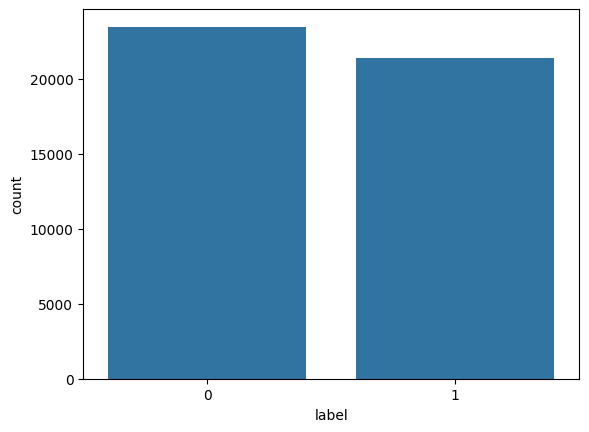

In [15]:
# This plot clearly shows data is almost balanced

sns.countplot(x=news_df['label'] ,data=news_df)

<Axes: xlabel='count', ylabel='subject'>

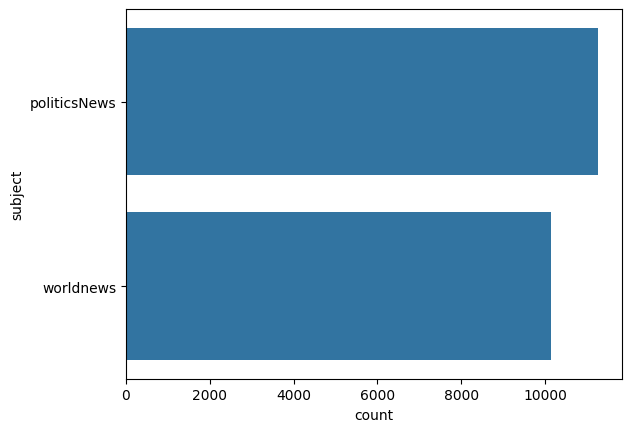

In [16]:
#Exploring the 'Subject' column in True and Fake Data
sns.barplot(y=true_df['subject'].value_counts().index,x=true_df['subject'].value_counts(),
            orient='h')

<Axes: xlabel='count', ylabel='subject'>

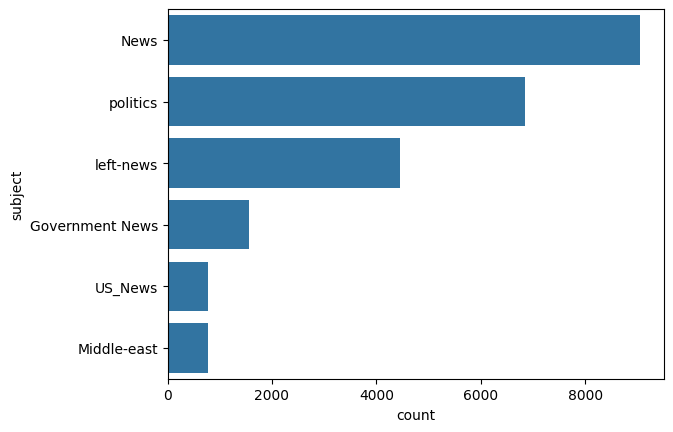

In [17]:
#Exploring the 'Subject' column¶
sns.barplot(y=fake_df['subject'].value_counts().index,x=fake_df['subject'].value_counts(),
            orient='h')

In [18]:
df = news_df[['text','label']]

In [19]:
df.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [20]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
    return text


def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

In [21]:
df['text'] = df['text'].apply(lambda x:clean_text(x))


In [22]:
df.head()


,text,label
0,washington reuters the head of a conservative ...,1
1,washington reuters transgender people will be ...,1
2,washington reuters the special counsel investi...,1
3,washington reuters trump campaign adviser geor...,1
4,seattle washington reuters president donald tr...,1


In [24]:
import nltk
nltk.download('punkt_tab', quiet=True)

def remove_stopwords_from_sentence(sentence):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)


# Apply the function to the 'sentence' column
df['text'] = df['text'].apply(remove_stopwords_from_sentence)

In [25]:
df.head()

,text,label
0,washington reuters head conservative republica...,1
1,washington reuters transgender people allowed ...,1
2,washington reuters special counsel investigati...,1
3,washington reuters trump campaign adviser geor...,1
4,seattle washington reuters president donald tr...,1


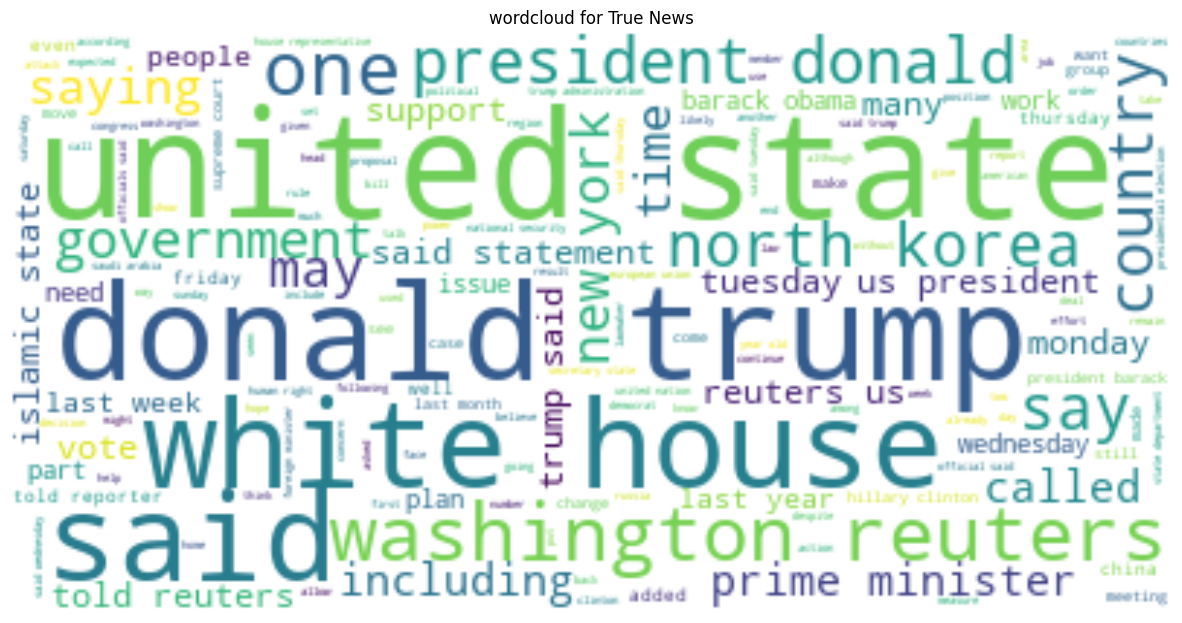

In [26]:
text = " ".join(i for i in df[df['label']==1]['text'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for True News')
plt.show()

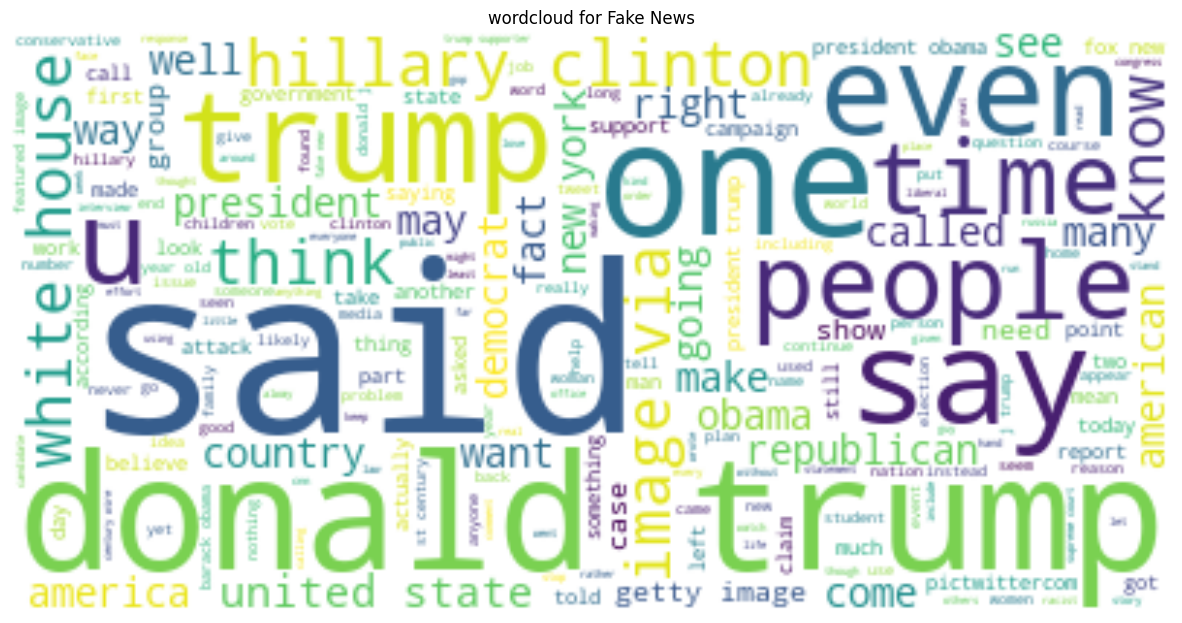

In [27]:
text = " ".join(i for i in df[df['label']==0]['text'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for Fake News')
plt.show()

In [28]:
sample_corpora = df['text'].iloc[:1].values
sample_corpora

array(['washington reuters head conservative republican faction us congress voted month huge expansion national debt pay tax cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republicans us representative mark meadows speaking cbs face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy even november congressional election campaigns approach republicans seek keep control congress president donald trump republicans want big budget increase military spending democrats also want proportional increases non defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration already willing say going increase non defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats sayin

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)


In general it is a way to make subsets from several strata of the main data. We Use the Train Data for Model Building and the Test Data for Model Testing/Validation. This function creates two new tables where the data is bifurcated on the basis of the parameters specified by the user.

In [30]:
y_train.value_counts(), y_test.value_counts()


(label
 0    18785
 1    17133
 Name: count, dtype: int64,
 label
 0    4696
 1    4284
 Name: count, dtype: int64)

1. using CountVectorizer    
2. using TF-IDF     
3. using TF-IDF with Bi-Grams

In [31]:
# create the pipline 
pipe = Pipeline([('cv', CountVectorizer()),
                ('svc', MultinomialNB())])

# fit the pipeline  
pipe.fit(X_train, y_train)

,steps,"[('cv', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


              precision    recall  f1-score   support

           0       0.96      0.95      0.96      4696
           1       0.95      0.96      0.95      4284

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



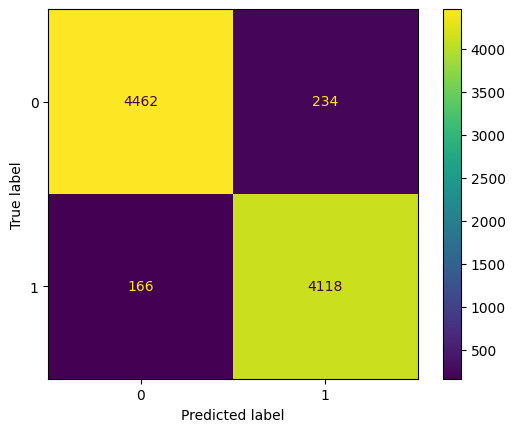

In [32]:
# create the classification report and plot the confusion matrix
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)

In [33]:
# create the pipline 
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('svc', MultinomialNB())])

# fit the pipeline  
pipe.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4696
           1       0.93      0.94      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



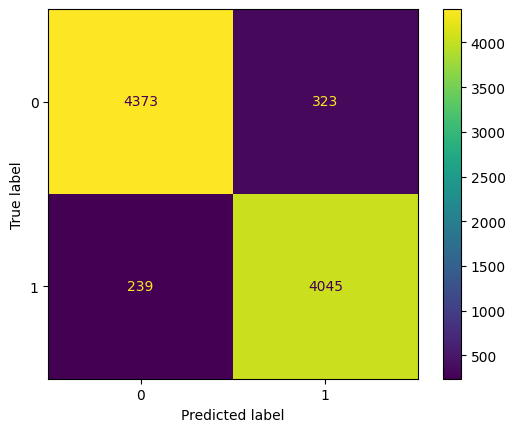

In [34]:
# create the classification report and plot the confusion matrix
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)

In [35]:
predict_train = pipe.fit(X_train, y_train).predict(X_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = pipe.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on train dataset :  0.9472409376914082
accuracy_score on test dataset :  0.9374164810690423
accuracy_score on test dataset :  0.9374164810690423


--- 5-Fold Cross-Validation Results ---
Individual CV Scores (5 folds): [0.95545657 0.95935412 0.96018931 0.95670333 0.95739942]
Mean CV Accuracy: 0.9578
Standard Deviation of CV Scores: 0.0017
Individual CV Scores (5 folds): [0.95545657 0.95935412 0.96018931 0.95670333 0.95739942]
Mean CV Accuracy: 0.9578
Standard Deviation of CV Scores: 0.0017

--- Final Model Evaluation on Training Set ---
Training Accuracy: 0.9774486329973829

--- Final Model Evaluation on Training Set ---
Training Accuracy: 0.9774486329973829
Test Accuracy: 0.9590200445434298

Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4696
           1       0.95      0.97      0.96      4284

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980


Confusion Matrix (on Test Set):
[[4459  237]
 [ 131 4153]]
Test Accuracy: 0.9590

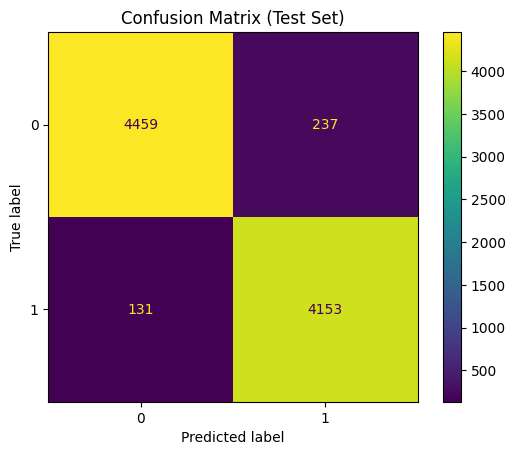

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Assuming X_train, y_train, X_test, y_test are already defined

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # TF-IDF vectorizer with bigrams
    ('clf', MultinomialNB())                        # Multinomial Naive Bayes classifier
])

# ----------------------------------------------------------------------
# 🥇 STEP 1: Perform 5-Fold Cross-Validation for Robust Performance Check
# ----------------------------------------------------------------------
# This step gives you an idea of how well the model generalizes on the training data.
print("--- 5-Fold Cross-Validation Results ---")
cv_scores = cross_val_score(
    estimator=pipeline, 
    X=X_train, 
    y=y_train, 
    cv=5, 
    scoring='accuracy'
)

print(f"Individual CV Scores (5 folds): {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV Scores: {np.std(cv_scores):.4f}")

# ----------------------------------------------------------------------
# 🥈 STEP 2: Fit the Full Model and Evaluate (Original Code Follows)
# ----------------------------------------------------------------------

# Fit the pipeline to the *entire* training data for final model
pipeline.fit(X_train, y_train)

# Predict on the training set
y_pred_train = pipeline.predict(X_train) # Renamed to y_pred_train for clarity

# Calculate accuracy on the *training set*
accuracy_train = accuracy_score(y_train, y_pred_train)
print("\n--- Final Model Evaluation on Training Set ---")
print("Training Accuracy:", accuracy_train)

# Predict on the *test set* (Crucial for final, unbiased performance)
y_pred_test = pipeline.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)


# Print classification report (using the TEST set is better practice)
print("\nClassification Report (on Test Set):")
print(classification_report(y_test, y_pred_test))

# Calculate confusion matrix (on Test Set)
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix (on Test Set):")
print(conf_matrix)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=pipeline.classes_)
disp.plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [40]:
import joblib
# Save the model to a .pkl file
joblib.dump(pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

In [38]:
# Load the model from the .pkl file
pipeline_loaded = joblib.load('model_pipeline.pkl')

# You can now use the loaded model for predictions or other operations
y_pred_loaded = pipeline_loaded.predict(X_test)